<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/1stSOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=2a5bc6e96030a9364397b836c7bbce525c403156286f2c455d64102c6aea0d4a
  Stored in directory: /root/.cache/pip/wheels/c8/29/ba/ee521d9a6af783a1e1efb1831fe4afdf526613849b3f58175b
Successfully built minisom


Data Preprocessing and Feature Scaling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np


data = pd.read_csv("educationnormalized_with_winners.csv")


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (1, 0.65, 0),  # Orange
    'Green': (0, 0.5, 0),         # Dark Green
    'The Brexit Party': (0.8, 0.4, 0), #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = data.drop(columns=labeling_columns)

#Feature Scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)


normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = data[labeling_columns]

print(normalized_df.head())

   Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
0                                           0.812314                                                                                                                                                   
1                                           0.709788                                                                                                                                                   
2                                           0.322526                                                                                                                                                   
3                                           0.768664                                                                                                                                                   


Initialing SOM Algorithm and Training

In [ ]:

# Initialize and Train SOM
n_neurons = int(np.sqrt(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons
som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)

# Train the SOM
num_iterations = 500
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.09657609268262315


Plot the 2D SOM

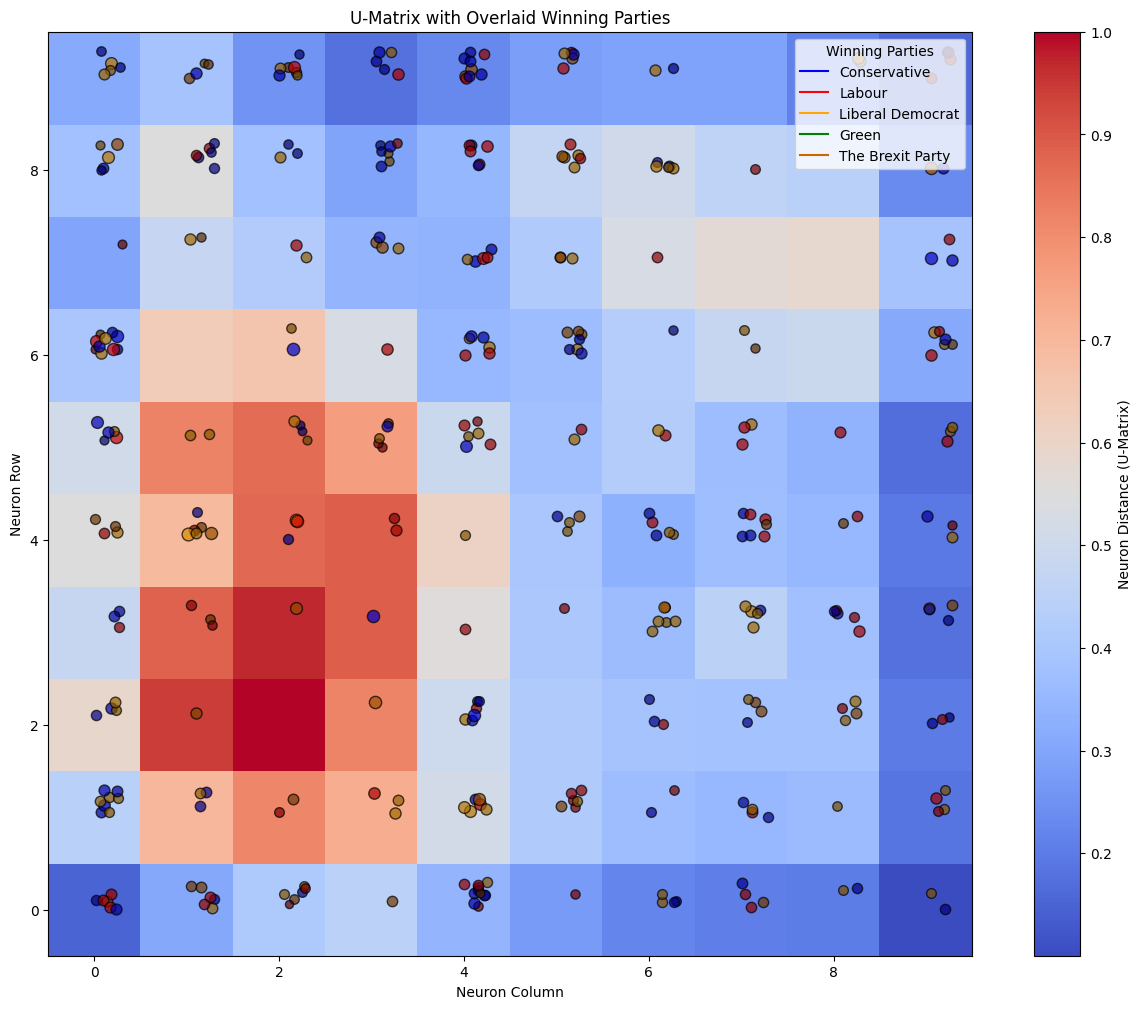

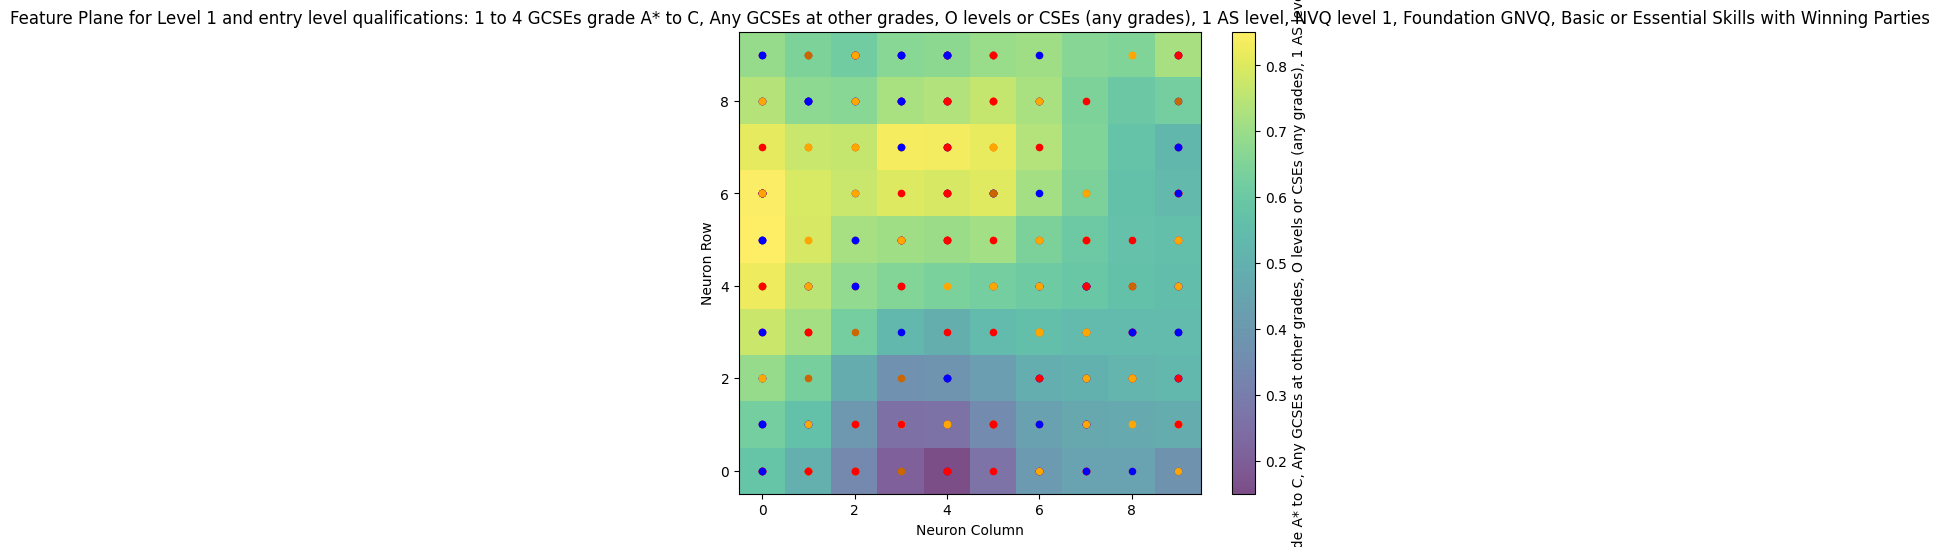

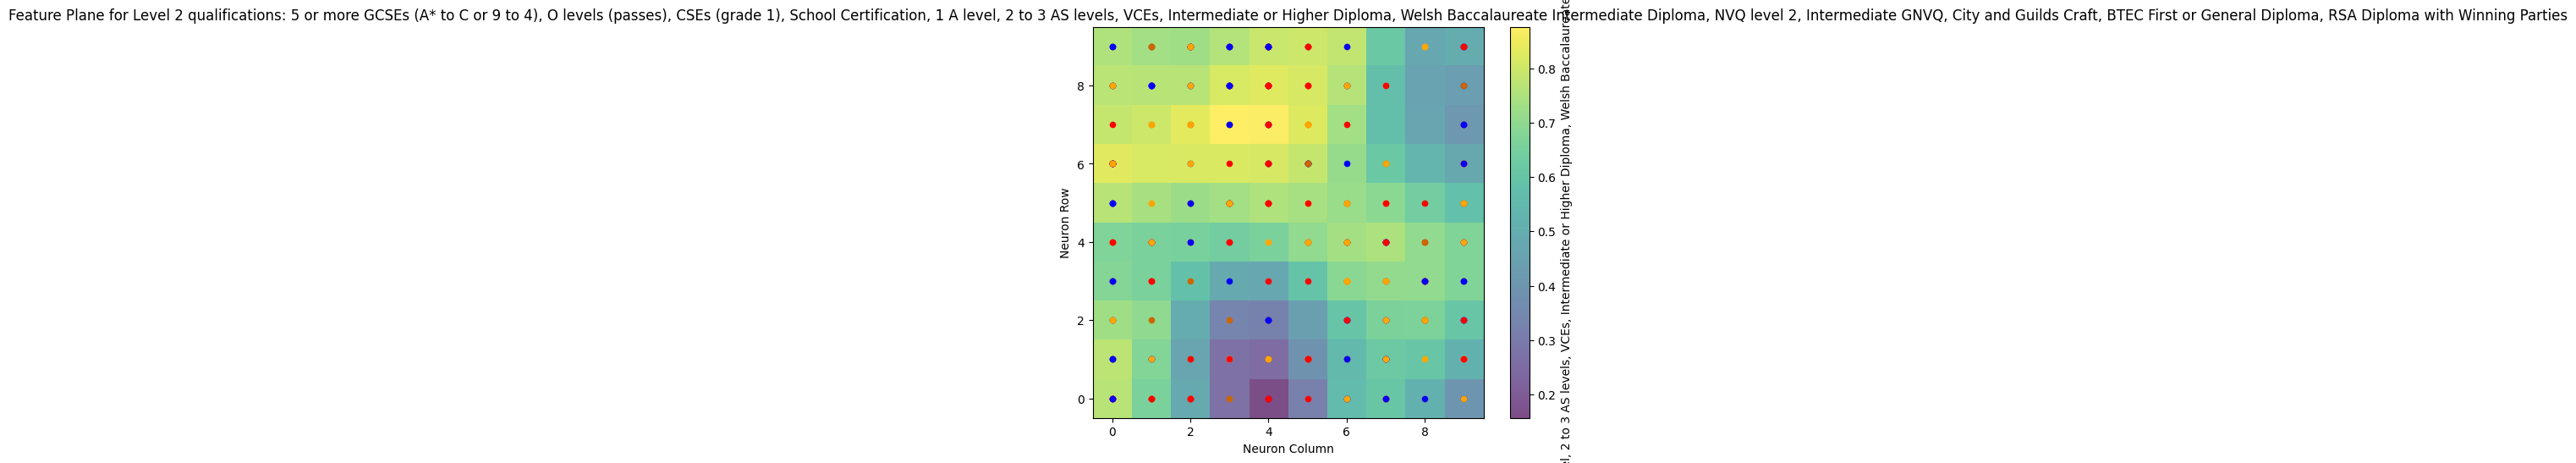

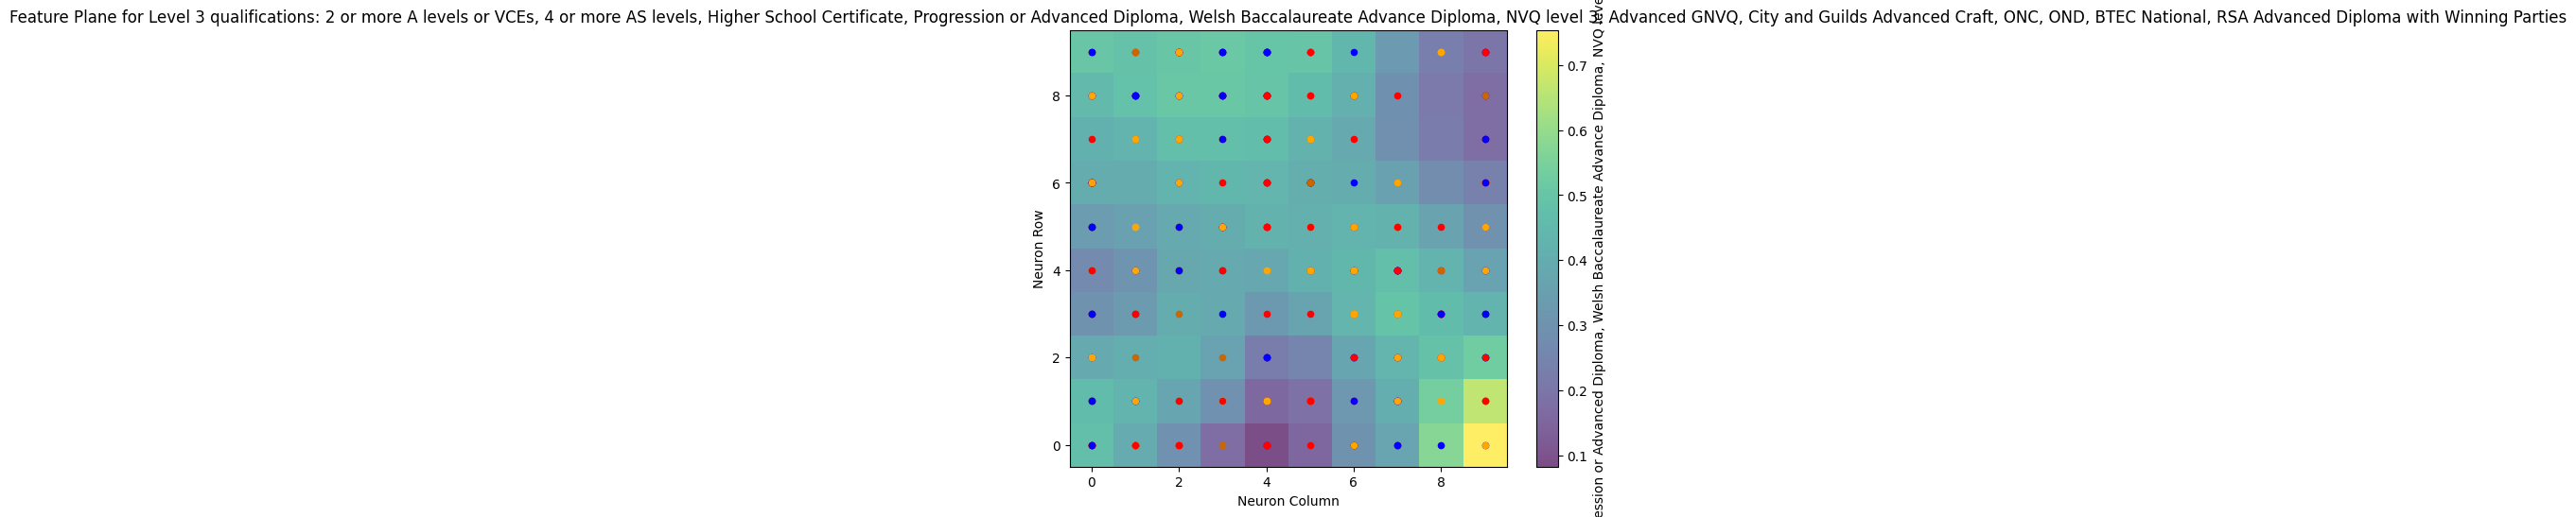

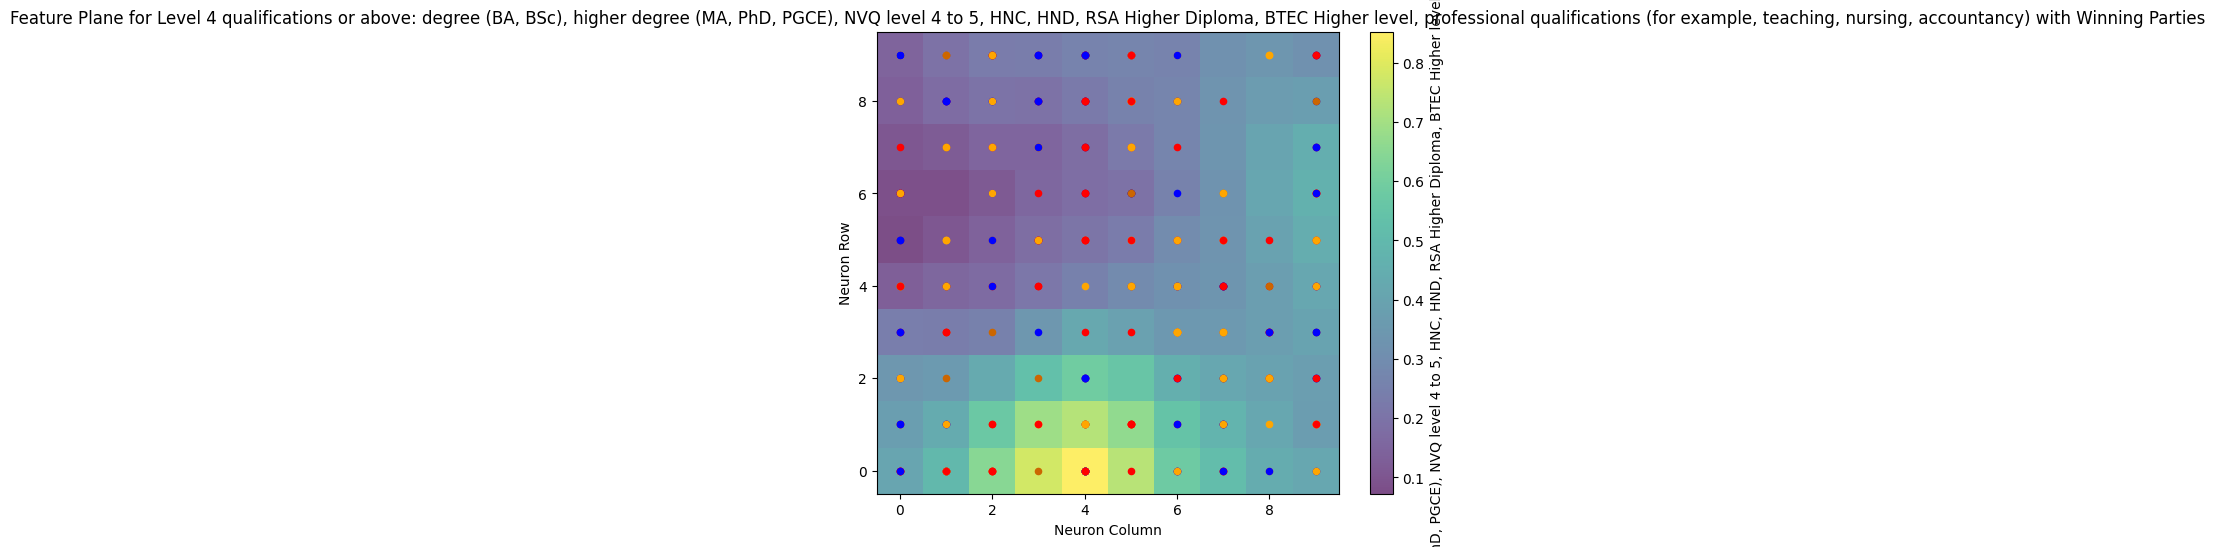

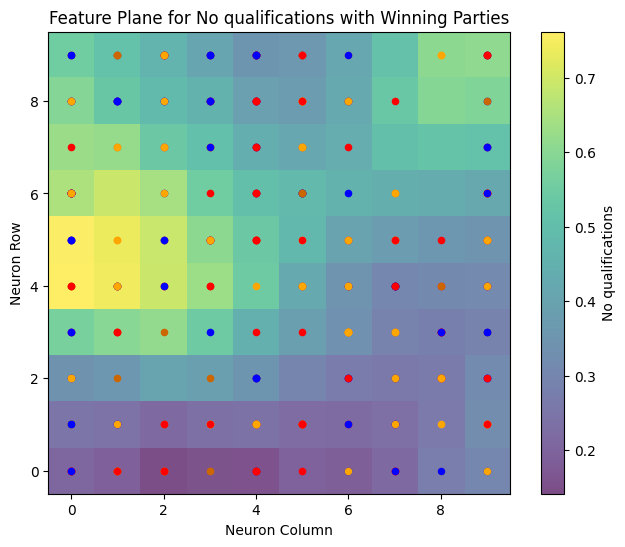

In [ ]:
#U-Matrix implementation


u_matrix = som.distance_map()
#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U-Matrix with Overlaid Winning Parties")
plt.imshow(u_matrix.T, cmap='coolwarm', origin='lower')
plt.colorbar(label="Neuron Distance (U-Matrix)")

# Overlayying the winning parties on the grid
for _, row in normalized_df.iterrows():
    neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
    party = row['Winning Party']
    vote_share = row['Winning Vote Share']

    if party in party_colors:
        base_color = np.array(party_colors[party])
        adjusted_color = np.clip(base_color * vote_share, 0, 1)
        plt.scatter(neuron_col + 0.3 * np.random.rand(),
                    neuron_row + 0.3 * np.random.rand(),
                    s=vote_share * 100,
                    color=adjusted_color,
                    alpha=0.7, edgecolors='k')

# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()



# 1. Feature Plane Visualization for Education Levels

education_features = [
    "Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills",
    "Level 2 qualifications: 5 or more GCSEs (A* to C or 9 to 4), O levels (passes), CSEs (grade 1), School Certification, 1 A level, 2 to 3 AS levels, VCEs, Intermediate or Higher Diploma, Welsh Baccalaureate Intermediate Diploma, NVQ level 2, Intermediate GNVQ, City and Guilds Craft, BTEC First or General Diploma, RSA Diploma",
    "Level 3 qualifications: 2 or more A levels or VCEs, 4 or more AS levels, Higher School Certificate, Progression or Advanced Diploma, Welsh Baccalaureate Advance Diploma, NVQ level 3; Advanced GNVQ, City and Guilds Advanced Craft, ONC, OND, BTEC National, RSA Advanced Diploma",
    "Level 4 qualifications or above: degree (BA, BSc), higher degree (MA, PhD, PGCE), NVQ level 4 to 5, HNC, HND, RSA Higher Diploma, BTEC Higher level, professional qualifications (for example, teaching, nursing, accountancy)",
    "No qualifications"
]

# 2. Combining with Winning Party Colors

for feature_name in education_features:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='viridis', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {feature_name} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    for index, row in normalized_df.iterrows():
        neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        winning_party = row['Winning Party']
        if winning_party in party_colors:
          plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=20)

    plt.show()








# from matplotlib.patches import Patch
# from pylab import bone, pcolor, colorbar, plot, axis, show
# plt.figure(figsize=(16,12))
# bone()
# pcolor(som.distance_map().T)
# colorbar()

# for index, row in normalized_df.iterrows():
#         neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
#         winning_party = row['Winning Party']
#         if winning_party in party_colors:
#           # plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=20)
#           plot(neuron_row +.5, neuron_col +.5, 'o', markerfacecolor=party_colors.get(winning_party, 'gray'), markeredgecolor='none', markersize=10, markeredgewidth=2)

# plt.title("SOM Clusters with Winning Parties and Vote Share Intensities")
# axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
# show()



# u_matrix = som.distance_map()

# # # Plot U-Matrix
# plt.figure(figsize=(16, 12))
# plt.title("U-Matrix with Overlaid Winning Parties")
# plt.imshow(u_matrix.T, cmap='coolwarm', origin='lower')
# plt.colorbar(label="Neuron Distance (U-Matrix)")

# # Overlay winning parties on the U-Matrix
# for index, row in normalized_df.iterrows():
#     input_features = row[features.columns].values.astype(np.float64)
#     winner = som.winner(input_features)
#     party = row['Winning Party']
#     if party in party_colors:
#       vote_share = row['Winning Vote Share']

#       base_color = np.array(party_colors.get(party, (0.5, 0.5, 0.5)))
#       adjusted_color = base_color * (vote_share)
#       adjusted_color = np.clip(adjusted_color, 0, 1)

#       plt.scatter(winner[1] + 0.1 + np.random.rand() * 0.3,  #for visibility scatters the neurons away from each other to avoid clusters that are on top of each other
#                   winner[0] + 0.1 + np.random.rand() * 0.3,
#                   s= vote_share * 100,
#                   color=adjusted_color,
#                   alpha=0.7,
#                   edgecolors='k')

# # Add legend for parties
# legend_elements = [Line2D([0], [0], color=party_colors[party], label=party, markersize=10)
#                    for party in party_colors.keys()]
# plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties", frameon=False)

# plt.xlabel("Neuron Column")
# plt.ylabel("Neuron Row")
# plt.show()










# grouped_data = normalized_df.groupby(['Neuron Row', 'Neuron Col']).agg({
#     'Winning Party': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',# Dominant party in the cluster
#     'Winning Vote Share': 'mean'           # Average vote share
# }).reset_index()

# #Prepare grid and colors
# u_matrix = som.distance_map()  # U-Matrix shows distances between neurons
# plt.figure(figsize=(12, 10))
# plt.title("SOM Clusters with Winning Parties and Vote Share Intensities")

# # Scatter Plot
# for index, row in normalized_df.iterrows():
#     r, c = row['Neuron Row'], row['Neuron Col']
#     party = row['Winning Party']

#     if party in party_colors:
#       vote_share = row['Winning Vote Share']

#       base_color = np.array(party_colors.get(party, (0.5, 0.5, 0.5)))
#       adjusted_color = base_color * (vote_share)
#       adjusted_color = np.clip(adjusted_color, 0, 1)

#       plt.scatter(c + np.random.rand() * 0.5,
#                   r + np.random.rand() * 0.5,
#                   s=vote_share * 500,
#                   color=adjusted_color,
#                   label=party if index == 0 else "",
#                   alpha=0.8, edgecolors='k')

# #Plot centroids of neurons
# centroids = som.get_weights()
# for i in range(n_neurons):
#     for j in range(m_neurons):
#         plt.scatter(j, i, c='k', s=10, marker='x', edgecolors='k')

# legend_elements = [Line2D([0], [0], color=party_colors[party], label=party, markersize=10)for party, color in party_colors.items()]

# plt.legend(handles=legend_elements, loc='upper right', fontsize='small', frameon=False)

# plt.gca().invert_yaxis()  # Align SOM's convention

# plt.xlabel("Neuron Column")
# plt.ylabel("Neuron Row")

# plt.show()




# import matplotlib.pyplot as plt
# import numpy as np

# Assuming you have the following variables:
# - som: Your trained MiniSom object
# - features: Your pandas DataFrame containing the features
# - normalized_df: Your pandas DataFrame with normalized features, winning party, and neuron coordinates
# - party_colors: Your dictionary mapping party names to colors




# plt.figure(figsize=(20, 10))
# for idx, feature in enumerate(features.columns):
#     feature_plane = som.get_weights()[:, :, idx]
#     plt.subplot(2, 3, idx + 1)
#     plt.imshow(feature_plane, cmap='viridis', origin='lower')
#     plt.colorbar(label=feature)
#     plt.title(f"{feature} Feature Plane")
#     plt.xlabel("Neuron Column")
#     plt.ylabel("Neuron Row")
#     for index, row in normalized_df.iterrows():
#         neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
#         winning_party = row['Winning Party']
#         if winning_party in party_colors:
#           plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=20)  # Adjust marker size as needed

#     plt.show()


